# Personal Information
Name: **Mara Smeets**

StudentID: **14629747**

Email: [**mara.smeets@student.uva.nl**](youremail@student.uva.nl)

Submitted on: **DD.MM.YYYY**

Deliverable: A PDF of your Jupyter notebook that has a minimal length of 3 pages and includes your 
GitHub link

https://github.com/Mara4444/MSc-thesis-2024


#### Import relevant packages

In [2]:
# Importshttps://file+.vscode-resource.vscode-cdn.net/c%3A/Users/maras/OneDrive/Documents/UvA/ml-icl/EDA/GSM8K_Reasoning_steps_Shi.png
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
from datasets import load_dataset
import nltk
from nltk.tokenize import sent_tokenize
import re

nltk.download('punkt')

%matplotlib inline



c:\Users\maras\anaconda3\envs\eda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\maras\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### Contents

1. Data context
2. The MGSM benchmark
3. Machine translation
4. Chain-of-thought experiments
5. Language similarity

# 1. Data Context
In this research, the base data source is the MGSM benchmark (Shi et al., 2022). 

The MGSM benchmark is a multilingual grade-school math problem dataset. This benchmark is commonly used to test the performance of LLMs on arithmetic reasoning tasks. It consists of the first 250 examples from the GSM8K official test example list (Cobbe et al., 2021). The 250 math problems are human-translated into a typologically diverse set of ten languages other than English: Bengali, Chinese, French, German, Japanese, Russian, Spanish, Swahili, Telugu, and Thai. The original English set of 250 math problems is also included in order to construct a baseline performance. The dataset is loaded via huggingface.

Furthermore, the World Atlas of Language Structures database (WALS) is used in order to determine a similarity metric between languages (Dryer et al., 2013). This database consists of structural (e.g. phonological, grammatical and lexical) properties of languages.

# 2. The MGSM benchmark

#### Data loading

In [3]:
mgsm_en = load_dataset("juletxara/mgsm","en")        
mgsm_bn = load_dataset("juletxara/mgsm","bn")     
mgsm_de = load_dataset("juletxara/mgsm","de")     
mgsm_es = load_dataset("juletxara/mgsm","es")     
mgsm_fr = load_dataset("juletxara/mgsm","fr")     
mgsm_ja = load_dataset("juletxara/mgsm","ja")     
mgsm_ru = load_dataset("juletxara/mgsm","ru")     
mgsm_sw = load_dataset("juletxara/mgsm","sw")     
mgsm_te = load_dataset("juletxara/mgsm","te")     
mgsm_th = load_dataset("juletxara/mgsm","th")     
mgsm_zh = load_dataset("juletxara/mgsm","zh")     

The first 250 test questions of the GSM8K benchmark is included in order to explore the original answers.

In [4]:
gsm8k = load_dataset('gsm8k','main')

questions = gsm8k['test']['question']
answers = gsm8k['test']['answer']

gsm8k = pd.DataFrame(data = {'question' : questions[:250],
                             'answer' : answers[:250]})
gsm8k

,question,answer
0,Janet’s ducks lay 16 eggs per day. She eats th...,Janet sells 16 - 3 - 4 = <<16-3-4=9>>9 duck eg...
1,A robe takes 2 bolts of blue fiber and half th...,It takes 2/2=<<2/2=1>>1 bolt of white fiber\nS...
2,Josh decides to try flipping a house. He buys...,The cost of the house and repairs came out to ...
3,James decides to run 3 sprints 3 times a week....,He sprints 3*3=<<3*3=9>>9 times\nSo he runs 9*...
4,"Every day, Wendi feeds each of her chickens th...","If each chicken eats 3 cups of feed per day, t..."
...,...,...
245,There are 4 snails in one aquarium and 32 snai...,The difference between the number of snails is...
246,Jeans makeup artist charges her $250 an hour. ...,Jean pays 250*6=$<<250*6=1500>>1500 a day\nSo ...
247,Isabelle bought party supplies for her little ...,Isabelle spent 12 + 43 + 15 + 4 + 22 = $<<12+4...
248,A chef bought 4 bags of onions. Each bag weigh...,A bag of onions cost $1.50 x 50 = $<<1.5*50=75...


Note that all answers are integers (thus no decimals). First, we want to evaluate the complexity of the 250 arithmetic questions. We expand the original queston and answer dataset with the respective length (=nr of characters), wordcount, nr of sentences, and for the answers specifically we count the number of mathematical operators ( +, -, /, *). These features could give a nice overview of the complexity of the 250 questions in the dataset.

In [5]:
# calculate length, word count and nr of sentences data for the question and the answer
### Questions
length = []
wordcount = []
sentencecount = []
    
for question in gsm8k["question"]:
    length.append(len(question))
    wordcount.append(len(question.strip().split(" ")))
    sentences = sent_tokenize(question)
    sentencecount.append(len(sentences))

gsm8k['Question length'] = length
gsm8k['Question wordcount'] = wordcount
gsm8k['Question nr_sentences'] = sentencecount

### Answers
length = []
wordcount = []
sentencecount = []

for answer in gsm8k["answer"]:
    length.append(len(answer))
    wordcount.append(len(answer.strip().split(" ")))
    sentences = sent_tokenize(answer)
    sentencecount.append(len(sentences))

gsm8k['Answer length'] = length
gsm8k['Answer wordcount'] = wordcount
gsm8k['Answer nr_sentences'] = sentencecount

# count number of mathematical operations
plus_countlist = []
min_countlist = []
div_countlist = []
mult_countlist = []

for answer in gsm8k['answer']:
    # first remove the operation parts between << >> 
    pattern = r'<<.*?>>'
    answer = re.sub(pattern, '', answer)
    
    # then count the number of math operations in each answer
    plus_count = 0
    min_count = 0
    div_count = 0
    mult_count = 0
    for i in answer:
        if i == '+':
            plus_count += 1
        elif i == '-':
            min_count += 1
        elif i == '/':
            div_count +=1
        elif i == '*':
            mult_count += 1
    plus_countlist.append(plus_count)
    min_countlist.append(min_count)
    div_countlist.append(div_count)
    mult_countlist.append(mult_count)

gsm8k['Plus'] = plus_countlist
gsm8k['Min'] = min_countlist
gsm8k['Divisions'] = div_countlist
gsm8k['Multiplications'] = mult_countlist
gsm8k['Nr_operations'] = gsm8k[['Plus', 'Min', 'Divisions','Multiplications']].sum(axis=1)

The distribution of the main question characteristics (length, word count and number of sentences) of the English MGSM benchmark are show below.

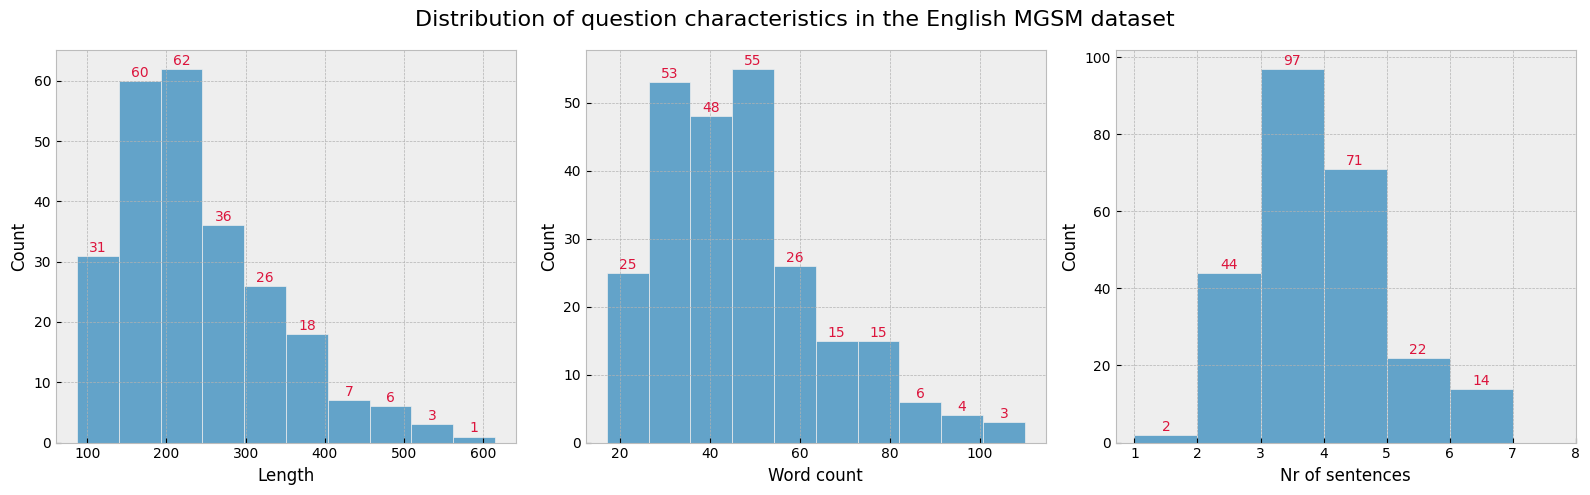

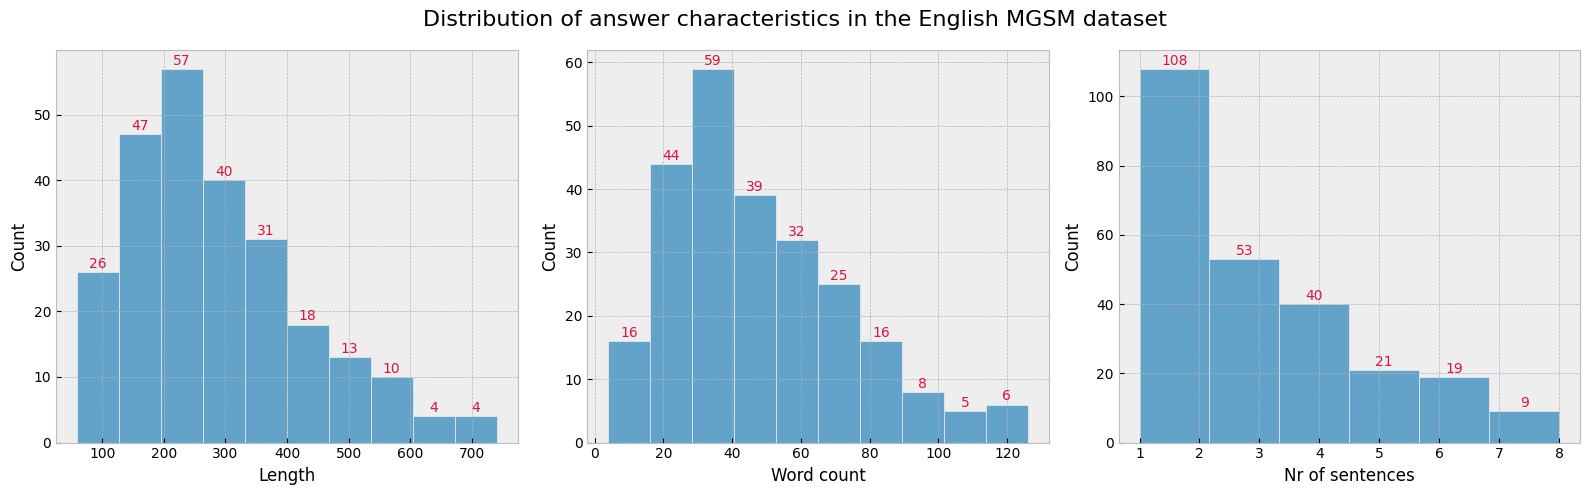

([<matplotlib.axis.XTick at 0x1abea36c830>,
 [Text(0, 0, '0'),
  Text(2, 0, '2'),
  Text(4, 0, '4'),
  Text(6, 0, '6'),
  Text(8, 0, '8'),
  Text(10, 0, '10'),
  Text(12, 0, '12'),
  Text(14, 0, '14'),
  Text(16, 0, '16'),
  Text(18, 0, '18')])

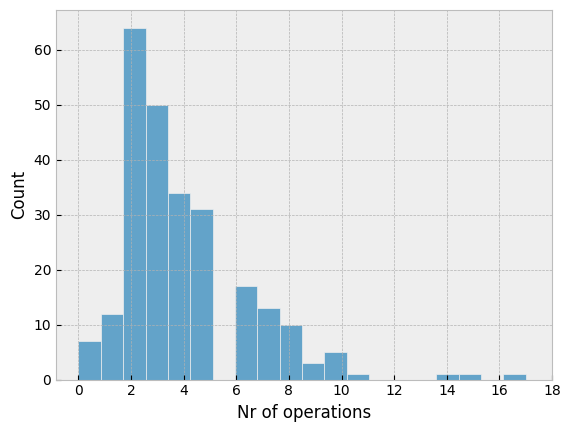

In [6]:
### create plots question
plt.style.use('bmh')
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot for 'length' column
sns.histplot(gsm8k['Question length'], kde=False, bins=10, ax=axes[0])
axes[0].set_xlabel('Length')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

# Plot for 'wordcount' column
sns.histplot(gsm8k['Question wordcount'], kde=False, bins=10, ax=axes[1])
axes[1].set_xlabel('Word count')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

# Plot for 'nr_sentences' column
sns.histplot(gsm8k['Question nr_sentences'], kde=False, bins=6, ax=axes[2])
axes[2].set_xlabel('Nr of sentences')
axes[2].set_xticks(np.arange(1,9,1))
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

fig.suptitle('Distribution of question characteristics in the English MGSM dataset', fontsize=16)
plt.tight_layout()
plt.show()

# create plots
plt.style.use('bmh')
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot for 'length' column
sns.histplot(gsm8k['Answer length'], kde=False, bins=10, ax=axes[0])
axes[0].set_xlabel('Length')
for p in axes[0].patches:
    axes[0].annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

# Plot for 'wordcount' column
sns.histplot(gsm8k['Answer wordcount'], kde=False, bins=10, ax=axes[1])
axes[1].set_xlabel('Word count')
for p in axes[1].patches:
    axes[1].annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

# Plot for 'nr_sentences' column
sns.histplot(gsm8k['Answer nr_sentences'], kde=False, bins=6, ax=axes[2])
axes[2].set_xlabel('Nr of sentences')
axes[2].set_xticks(np.arange(1,9,1))
for p in axes[2].patches:
    axes[2].annotate(f'{p.get_height():.0f}\n',
                     (p.get_x() + p.get_width() / 2, p.get_height()), ha='center', va='center', color='crimson')

fig.suptitle('Distribution of answer characteristics in the English MGSM dataset', fontsize=16)
plt.tight_layout()
plt.show()


### nr of mathematical operations
plt.style.use('bmh')

# Plot for 'length' column
sns.histplot(gsm8k['Nr_operations'], kde=False, bins=20)
plt.xlabel('Nr of operations')
plt.xticks(np.arange(0,20,2))


We also want to check if the main characteristics correlate between the question and answer.

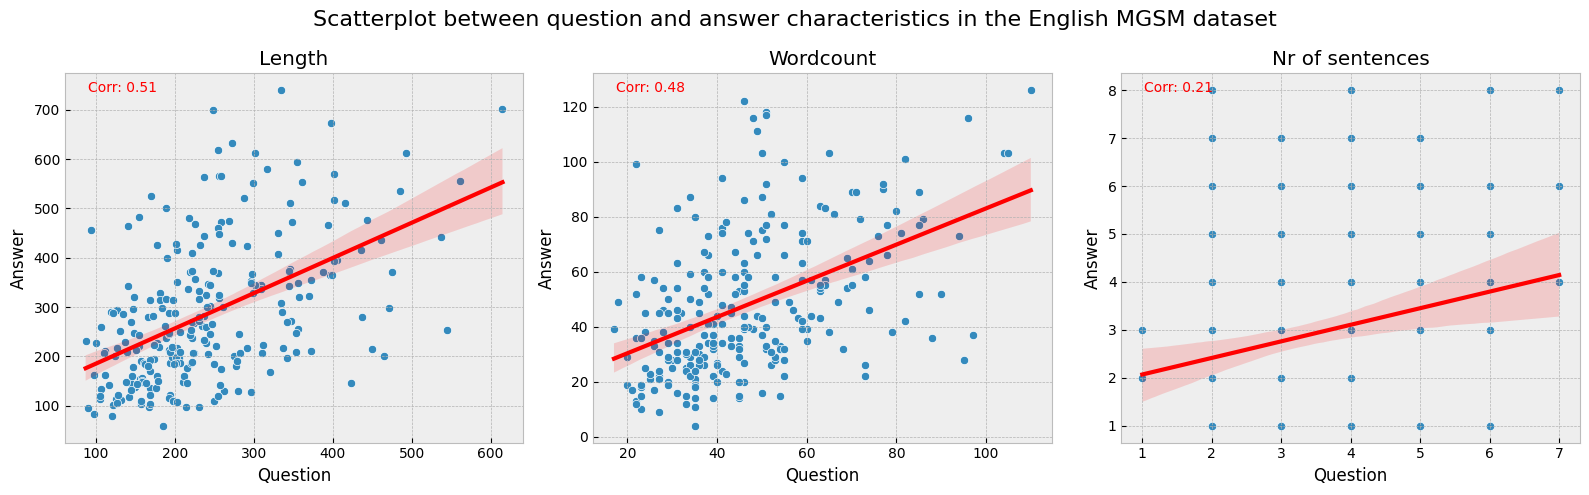

In [7]:
# create plots
plt.style.use('bmh')
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Plot for 'length' column
sns.scatterplot(x=gsm8k['Question length'],y=gsm8k['Answer length'], ax=axes[0])
sns.regplot(x=gsm8k['Question length'], y=gsm8k['Answer length'], ax=axes[0], scatter=False, color='red')
correlation = gsm8k['Question length'].corr(gsm8k['Answer length'])
axes[0].set_title('Length')
axes[0].set_xlabel('Question')
axes[0].set_ylabel('Answer')
axes[0].annotate(f'Corr: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='red')

# Plot for 'wordcount' column
sns.scatterplot(x=gsm8k['Question wordcount'],y=gsm8k['Answer wordcount'], ax=axes[1])
sns.regplot(x=gsm8k['Question wordcount'], y=gsm8k['Answer wordcount'], ax=axes[1], scatter=False, color='red')
correlation = gsm8k['Question wordcount'].corr(gsm8k['Answer wordcount'])
axes[1].set_title('Wordcount')
axes[1].set_xlabel('Question')
axes[1].set_ylabel('Answer')
axes[1].annotate(f'Corr: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='red')


# Plot for 'nr_sentences' column
sns.scatterplot(x=gsm8k['Question nr_sentences'],y=gsm8k['Answer nr_sentences'],ax=axes[2])
sns.regplot(x=gsm8k['Question nr_sentences'], y=gsm8k['Answer nr_sentences'], ax=axes[2], scatter=False, color='red')
correlation = gsm8k['Question nr_sentences'].corr(gsm8k['Answer nr_sentences'])
axes[2].set_title('Nr of sentences')
axes[2].set_xlabel('Question')
axes[2].set_ylabel('Answer')
axes[2].annotate(f'Corr: {correlation:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', fontsize=10, color='red')

fig.suptitle('Scatterplot between question and answer characteristics in the English MGSM dataset', fontsize=16)
plt.tight_layout()
plt.show()

Each problem requires two to eight steps to solve according to the official solution and the answer for each question is a number value (Figure 1).

![image](GSM8K_Reasoning_steps_Shi.png)

Figure 1: Distribution of the number of reasoning steps in the official solution of the 250 MGSM benchmark questions (Shi et al., 2022).

Distribution of the question characteristics for all languages >>> **better to show in boxplot shape to identify outliers**

In [8]:
# data = {'Language' : ["English"]*250+["Bengali"]*250 + ["German"]*250 + ["Spanish"]*250 + ["French"]*250 + ["Japanese"]*250 + ["Russian"]*250 + ["Swahili"]*250 + ["Telugu"]*250 + ["Thai"]*250 + ["Chinese"]*250,
#         'Question': mgsm_en["test"]["question"] + mgsm_bn["test"]["question"] + mgsm_de["test"]["question"] + mgsm_es["test"]["question"] + mgsm_fr["test"]["question"] + mgsm_ja["test"]["question"] + mgsm_ru["test"]["question"] + mgsm_sw["test"]["question"] + mgsm_te["test"]["question"] + mgsm_th["test"]["question"] + mgsm_zh["test"]["question"]}

# df = pd.DataFrame(data=data)

# length = []
# wordcount = []
# sentencecount = []
    
# for question in df["Question"]:
#     length.append(len(question))
#     wordcount.append(len(question.strip().split(" ")))
#     sentences = sent_tokenize(question)
#     sentencecount.append(len(sentences))

# df['Length'] = length
# df['Wordcount'] = wordcount
# df['Nr_sentences'] = sentencecount

# # Create FacetGrid with one row per language
# languages = df['Language'].unique()
# num_languages = len(languages)
# num_cols = 3  

# fig, axes = plt.subplots(num_languages, num_cols, figsize=(10, 3*num_languages))

# # Iterate over each language and create subplots
# for i, language in enumerate(languages):

#     lang_df = df[df['Language'] == language]
    
#     # Plot 'Length'
#     ax = axes[i][0]
#     sns.histplot(data=lang_df, x='Length', kde=False, bins=10, ax=ax)
#     ax.set_xlabel('Length')
#     ax.set_title(f'{language}')
#     ax.set_xticks(np.arange(0,700,100))
    
#     # Plot 'Wordcount'
#     ax = axes[i][1]
#     sns.histplot(data=lang_df, x='Wordcount', kde=False, bins=10, ax=ax)
#     ax.set_xlabel('Word count')
#     ax.set_title(f'{language}')
#     ax.set_xticks(np.arange(0,120,20))
    
#     # Plot 'Nr_sentences'
#     ax = axes[i][2]
#     sns.histplot(data=lang_df, x='Nr_sentences', kde=False, bins=6, ax=ax)
#     ax.set_xlabel('Nr of sentences')
#     ax.set_title(f'{language}')
#     ax.set_xticks(np.arange(1,8,1))

# # fig.suptitle('Distribution of question characteristics in the MGSM dataset for each language', fontsize=16)
# plt.tight_layout()
# plt.show()


The MGSM benchmark consists of 8 identical exemplars for each language that can be used in the few-shot setting. The English exemplars are also translated into the languages of the language set.

In [9]:
# show data exemplar data and preview
exemplars = pd.DataFrame(data={'question': mgsm_en['train']['question'],
                               'answer': mgsm_en['train']['answer']})
exemplars

# df = pd.DataFrame(data={'language' : ['eng_Latn']*8 + ['ben_Beng']*8 + ['deu_Latn']*8 + ['fre_Latn']*8 + ['spa_Latn']*8 + ['tel_Telu']*8 + ['tha_Thai']*8 + ['jap_Japn']*8 + ['zho_Hant']*8 + ['rus_Cyrl']*8 + ['swa_Latn']*8,
#                         'question': mgsm_en['train']['question']+ mgsm_bn['train']['question'] + mgsm_de['train']['question'] + mgsm_fr['train']['question'] + mgsm_es['train']['question'] + mgsm_te['train']['question'] + mgsm_th['train']['question'] + mgsm_ja['train']['question'] + mgsm_zh['train']['question'] + mgsm_ru['train']['question'] + mgsm_sw['train']['question'],
#                         'answer': mgsm_en['train']['answer'] + mgsm_bn['train']['answer'] + mgsm_de['train']['answer'] + mgsm_fr['train']['answer'] + mgsm_es['train']['answer'] + mgsm_te['train']['answer'] + mgsm_th['train']['answer'] + mgsm_ja['train']['answer'] + mgsm_zh['train']['answer'] + mgsm_ru['train']['answer'] + mgsm_sw['train']['answer']
#                         })

# df 

,question,answer
0,Question: Roger has 5 tennis balls. He buys 2 ...,Step-by-Step Answer: Roger started with 5 ball...
1,Question: There were nine computers in the ser...,Step-by-Step Answer: There are 4 days from mon...
2,Question: Leah had 32 chocolates and her siste...,Step-by-Step Answer: Leah had 32 chocolates an...
3,"Question: Shawn has five toys. For Christmas, ...",Step-by-Step Answer: He has 5 toys. He got 2 f...
4,Question: Michael had 58 golf balls. On tuesda...,Step-by-Step Answer: Michael started with 58 g...
5,Question: Olivia has $23. She bought five bage...,Step-by-Step Answer: 5 bagels for $3 each shou...
6,Question: Jason had 20 lollipops. He gave Denn...,Step-by-Step Answer: Jason started with 20 lol...
7,Question: If there are 3 cars in the parking l...,Step-by-Step Answer: There are 3 cars in the b...


# 3. Machine translation

The MGSM benchmark is translated into other languages in order to perform relevant experiments. The NLLB-200-3.3B model is used to perform the machine translations. As translations from English show the best performance, the English MGSM benchmark is machine translated into the other languages in the targeted list. 

The aim is to experiment on a diverse language set based on language characteristics and have different representations in the Llama-2 and Bloomz training corpus. The main demand for the languages to include occur in the pretraining corpus of both LLMs. Another demand for languages that are not in the standard MGSM benchmark is that they are available in the NLLB-200 model for translation. A set of 7 languages other than English is selected for the experiments. The languages that are available in the original MGSM benchmark and do not need to be machine-translated are indicated with an \*. The experimental language set is: Catalan, Chinese\*, French\*, Indonesian, Portuguese, Spanish\* and Vietnamese. The distribution of the target languages in the pretraining corpus of both models is shown in table 

In [10]:
# len(["afr_Latn","arb_Arab","ban_Latn","bel_Cyrl","ben_Beng","bod_Tibt", "bos_Latn",
#      "bul_Cyrl","ces_Latn", "cat_Latn","dan_Latn", "deu_Latn","ell_Grek","eng_Latn",
#      "est_Latn", "fin_Latn", "fra_Latn","hat_Latn", "heb_Hebr","hin_Deva","hun_Latn", 
#      "ind_Latn", "ita_Latn","jav_Latn", "jpn_Jpan", "khm_Khmr","kor_Hang", "lao_Laoo",
#      "mai_Deva", "mar_Deva", "mni_Beng","mya_Mymr", "nno_Latn","nld_Latn", "npi_Deva",
#      "pol_Latn","por_Latn", "slk_Latn","quy_Latn","ron_Latn", "rus_Cyrl","slv_Latn", 
#      "spa_Latn", "srp_Cyrl", "swe_Latn", "swh_Latn", "tam_Taml", "tel_Telu","tgl_Latn", 
#      'tha_Thai',"tur_Latn","vie_Latn" , 'yue_Hant', "zho_Hant", "zsm_Latn","zul_Latn"])

llama_lang = ['bul_Cyrl','cat_Latn','ces_Latn','dan_Latn','deu_Latn', 'eng_Latn', 'fin_Latn','fre_Latn','hrv_Latn','hun_Latn','ind_Latn','ita_Latn','jpn_Japn','kor_Hang','nld_Latn','nno_Latn','pol_Latn','por_Latn','ron_Latn','rus_Cyrl','slv_Latn','spa_Latn','srp_Cyrl','swe_Latn','ukr_Cyrl','vie_Latn','zho_Hant']
# lang_set = ['cat_Latn','eng_Latn','fre_Latn','ind_Latn','por_Latn','spa_Latn','vie_Latn','zho_Hant']

print('nr of languages:',len(llama_lang))

nr of languages: 27


The ChrF++ score is used as a metric for machine translation quality. The NLLB language names and script are retrieved from the language FLORES-200 language codes and is merged with the ChrF++ data (Costa et al., 2022). 

In [11]:
# load the languages dataset
nllb_lang = pd.read_csv('nllb_languages.csv', sep=';') 

# load the metrics dataset
nllb_metrics = pd.read_csv('./nllb_metrics.csv', sep=',')

# extract script data for each language
nllb_lang['Script'] = nllb_lang['FLORES-200 code'].str[-4:]

# select only the metrics where English is the source language
nllb_metrics = nllb_metrics[nllb_metrics['direction'].str[:3] == 'eng']

# add column trg_lang and merge with nllb dataframe
nllb_metrics['trg_lang'] = nllb_metrics['direction'].str[9:]
nllb_lang = pd.merge(nllb_lang,nllb_metrics,left_on='FLORES-200 code', right_on = 'trg_lang')
nllb_lang.drop(columns=['trg_lang'], inplace=True)
nllb_lang.drop(columns=['direction'], inplace=True)

# insert row for English
nllb_lang.loc[len(nllb_lang.index)] = ['English','eng_Latn','Latn',None]

nllb_lang


C:\Users\maras\AppData\Local\Temp\ipykernel_24944\2916196785.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nllb_lang.loc[len(nllb_lang.index)] = ['English','eng_Latn','Latn',None]


,Language,FLORES-200 code,Script,chrf++
0,Acehnese (Arabic script),ace_Arab,Arab,19.7
1,Acehnese (Latin script),ace_Latn,Latn,37.4
2,Mesopotamian Arabic,acm_Arab,Arab,38.4
3,Ta’izzi-Adeni Arabic,acq_Arab,Arab,45.1
4,Tunisian Arabic,aeb_Arab,Arab,34.6
...,...,...,...,...
197,Chinese (Simplified),zho_Hans,Hans,22.3
198,Chinese (Traditional),zho_Hant,Hant,14.4
199,Standard Malay,zsm_Latn,Latn,66.3
200,Zulu,zul_Latn,Latn,53.5


### 3.1 Test questions

The 250 English MGSM test questions are translated into all relevant languages in the test set.

In [12]:
# show something data cleanliness ofzo? Boxplot of word count / sentencecount enzo to identify outliers?

### 3.2 Exemplars for few-shot experiments

The 8 exemplars of the MGSM benchmark are translated into all available languages using the NLLB-200-3.3B model.

In [13]:
# show length, nr of steps, word count, nr sentences on the English exemplars?
# show that some single words for 'question' are skipped and how we deal with them?

# 4. Chain-of-thought experiments
The Llama-2-7b-chat and Bloomz-7b1-mt model are used for the chain-of-thought (CoT) experiments (Touvron et al., 2023) (Muenninghof et al., 2023). The distribution of the selected languages in the pretraining corpus is retrieved from the papers.

<!-- ![image](Llama-2-languages..png) -->

<!-- Figure 3: Distribution the languages in the pretraining corpus of Llama-2 (Touvron et al., 2023). Here, the 'unknown language' category  mainly consists of programming code. -->


In [14]:
corpus = pd.read_csv('./training_corpus_llm.csv',sep=';')
corpus = corpus[corpus['Language'].isin(['English','Spanish','Catalan','Portuguese','Chinese','Vietnamese','Indonesian','French'])]
corpus = corpus[['Language','% in Bloomz-7b','% in Llama-2-7b']]
corpus

,Language,% in Bloomz-7b,% in Llama-2-7b
26,Vietnamese,2.6,0.08
27,Spanish,11.1,0.13
28,Portuguese,5.2,0.09
29,Indonesian,1.1,0.03
30,French,13.5,0.16
31,Catalan,1.1,0.04
32,Chinese,18.3,0.13
33,English,31.3,89.70


<!-- This research aims to test the effect of using languages in CoT reasoning that are more related to the target language than English. In order to test this, the main results on the MGSM and XCOPA benchmark for CoT in the native language as well as CoT in English are set as baseline performance. These results are extracted from Shi et al. (2022), Qin et al. (2023) and Huang et al. (2023). 

Here, “Direct” denotes the original input request will be given to model directly. “Native-CoT” signifies that the model generates inference steps in the same language as the input. “En-CoT” indicates the given non-English input request and returned with English CoT result.Translate-En” denotes we translate non-English input requests into English by Google translation API. **remove this one?** -->

No accuracy scores on the performance of the specific Llama-2-7B-chat-hf model on the MGSM benchmark are found. However, the accuracy scores for Llama-2-70B-chat-hf on the zero shot setting are found (Huang et al., 2023). Moreover, the 7B version shows an accuracy score of 14.6 on the GSM8K benchmark (Touvron et al., 2023)

In [15]:
### get for llama-2-7b from recent paper!
df = pd.DataFrame(data={'Language': ["English", "German", "Russian", "French", "Chinese", "Spanish", "Japanese", "Swahili", "Thai", "Bengali", "Telugu"], 
                        'Accuracy': [58.8, 48.0, 47.2, 45.6, 39.6, 50.4, 39.2, 10.0, 13.6, 17.2, 5.2]
                        })
df


,Language,Accuracy
0,English,58.8
1,German,48.0
2,Russian,47.2
3,French,45.6
4,Chinese,39.6
5,Spanish,50.4
6,Japanese,39.2
7,Swahili,10.0
8,Thai,13.6
9,Bengali,17.2


# 5. Language data

The WALS dataset is used as data source to quantify language similarity (Dryer et al., 2013).

#### Data loading

In [68]:
# load the WALS dataset
walsdata = pd.read_csv('../datasets/wals/language.csv', sep=',')

#### Data cleaning

First, we select only the languages in the walsdata set that are included in our experiment. The total dataset shows 27 languages and 202 columns.

In [69]:
# walsdata_test = walsdata.loc[walsdata['wals_code'].isin(["afr","bal","ben", "bos","bul","ctl","dsh", "ger","grk","eng","est", "fin", "fre","tib","hcr",
#                                                           "heb","hin","hun", "ind", "ita","jav", "jpn", "khm","kor", "lao","mai", "ams", "blr","mhi",
#                                                            "brm", "nor", "dut", "nep","pol","por", "svk","que","rus", "spa","swe", "swa", "rom","slo",
#                                                            "tml", "tel", 'tha',"tur","vie", 'cnt', "mnd", "mly","zul", "ukr","cze", "scr", "tag"])]
llama_lang_wals = ["bul","ctl","cze","dsh", "dut","ger","eng","fin","fre","scr","hun", "ind", "ita","jpn","kor","nor","pol","por","rus", "spa","swe","rom","slo",'tha',"vie","mnd","ukr"]
# len(llama_lang_wals)
# lang_set_wals = ["ctl","eng","fre","ind","por","spa","vie","mnd"]
walsdata_test = walsdata.loc[walsdata['wals_code'].isin(llama_lang_wals)]
print(walsdata_test.shape)

(27, 202)


The NLLB data is merged into the WALS dataset. The language names that differ between the datasets are manually changed.

In [70]:
# change merge column name
nllb_lang.rename(columns = {'Language':'Name'}, inplace = True) 

# Change names that differ in the nllb language name and wals language name
nllb_lang.loc[nllb_lang['Name'] == 'Norwegian Nynorsk', 'Name'] = 'Norwegian'
nllb_lang.loc[nllb_lang['Name'] == 'Serbian', 'Name'] = 'Serbian-Croatian'
nllb_lang.loc[nllb_lang['Name'] == 'Slovenian', 'Name'] = 'Slovene'
nllb_lang.loc[nllb_lang['Name'] == 'Chinese (Traditional)', 'Name'] = 'Mandarin'
# nllb_lang.loc[nllb_lang['Name'] == 'Standard Malay', 'Name'] = 'Malay'
# nllb_lang.loc[nllb_lang['Name'] == 'Modern Standard Arabic', 'Name'] = 'Arabic (Modern Standard)'
# nllb_lang.loc[nllb_lang['Name'] == 'Belarusian', 'Name'] = 'Belorussian'
# nllb_lang.loc[nllb_lang['Name'] == 'Yue Chinese', 'Name'] = 'Cantonese'
# nllb_lang.loc[nllb_lang['Name'] == 'Greek', 'Name'] = 'Greek (Modern)'
# nllb_lang.loc[nllb_lang['Name'] == 'Hebrew', 'Name'] = 'Hebrew (Modern)'
# nllb_lang.loc[nllb_lang['Name'] == 'Ayacucho Quechua', 'Name'] = 'Quechan'
# nllb_lang.loc[nllb_lang['Name'] == 'Standard Tibetan', 'Name'] = 'Tibetan (Standard Spoken)'

# merge the script values to the WALS dataset based on the language name
walsdata_test = pd.merge(walsdata_test, nllb_lang)

# rename walsdata language names for simplicity
walsdata_test.loc[walsdata_test['Name'] == 'Mandarin', 'Name'] = 'Chinese'
# walsdata_test.loc[walsdata_test['Name'] == 'Arabic (Modern Standard)', 'Name'] = 'Arabic'
# walsdata_test.loc[walsdata_test['Name'] == 'Greek (Modern)', 'Name'] = 'Greek'
# walsdata_test.loc[walsdata_test['Name'] == 'Hebrew (Modern)', 'Name'] = 'Hebrew'
# walsdata_test.loc[walsdata_test['Name'] == 'Tibetan (Standard Spoken)', 'Name'] = 'Tibetan'

walsdata_test.shape

(27, 205)

#### Exploring the data


- Missing data on other relevant features
- How are we going to deal with them? >> knn syntax url 

The method proposed by \cite{georgi2010comparing} is used to define a similarity metric based on WALS data. In order to deal with the large amount of missing values, all languages which have less than 25 features values filled are removed. This eliminates many languages that simply do not have enough features to be adequately represented. In addition, features that cover less than 10\% of the selected languages are removed.

A similarity measure that is designed to handle empty cells is used. Given two languages $A$ and $B$, the $\textrm{shared overlap}(A, B)$ is defined to as

\begin{equation}
    \textrm{Shared overlap}(A, B) = \frac{\textrm{\# Features with same values}}{\textrm{\# Features both filled out in WALS}}. 
\end{equation} \\

This measure can handle language pairs with many empty cells in WALS as it uses only features with cells filled out for both languages, and calculates the percentage of features with the same values. Moreover, as in \cite{lauscher2020} standard correlation is used to research the effect of language similarity in few-shot CoT reasoning. 

In [19]:
### feature groups in the walsdataset
genus = ['genus']
family = ['family']
macroarea = ['macroarea']
script = ['Script']
phonology = ['1A Consonant Inventories','2A Vowel Quality Inventories','3A Consonant-Vowel Ratio','4A Voicing in Plosives and Fricatives','5A Voicing and Gaps in Plosive Systems','6A Uvular Consonants','7A Glottalized Consonants','8A Lateral Consonants','9A The Velar Nasal','10A Vowel Nasalization','11A Front Rounded Vowels','12A Syllable Structure','13A Tone','14A Fixed Stress Locations','15A Weight-Sensitive Stress','16A Weight Factors in Weight-Sensitive Stress Systems','17A Rhythm Types','18A Absence of Common Consonants','19A Presence of Uncommon Consonants']
morphology = ['20A Fusion of Selected Inflectional Formatives','21A Exponence of Selected Inflectional Formatives','22A Inflectional Synthesis of the Verb','23A Locus of Marking in the Clause','24A Locus of Marking in Possessive Noun Phrases','25A Locus of Marking: Whole-language Typology','26A Prefixing vs. Suffixing in Inflectional Morphology','27A Reduplication','28A Case Syncretism','29A Syncretism in Verbal Person/Number Marking']
nominal_cat = ['30A Number of Genders','31A Sex-based and Non-sex-based Gender Systems','32A Systems of Gender Assignment','33A Coding of Nominal Plurality','34A Occurrence of Nominal Plurality','35A Plurality in Independent Personal Pronouns','36A The Associative Plural','37A Definite Articles','38A Indefinite Articles','39A Inclusive/Exclusive Distinction in Independent Pronouns','40A Inclusive/Exclusive Distinction in Verbal Inflection','41A Distance Contrasts in Demonstratives','42A Pronominal and Adnominal Demonstratives','43A Third Person Pronouns and Demonstratives','44A Gender Distinctions in Independent Personal Pronouns','45A Politeness Distinctions in Pronouns','46A Indefinite Pronouns','47A Intensifiers and Reflexive Pronouns','48A Person Marking on Adpositions','49A Number of Cases','50A Asymmetrical Case-Marking','51A Position of Case Affixes','52A Comitatives and Instrumentals','53A Ordinal Numerals','54A Distributive Numerals','55A Numeral Classifiers','56A Conjunctions and Universal Quantifiers','57A Position of Pronominal Possessive Affixes']
nominal_syn = ['58A Obligatory Possessive Inflection','59A Possessive Classification','60A Genitives, Adjectives and Relative Clauses','61A Adjectives without Nouns','62A Action Nominal Constructions','63A Noun Phrase Conjunction','64A Nominal and Verbal Conjunction']
verbal_cat = ['65A Perfective/Imperfective Aspect','66A The Past Tense','67A The Future Tense','68A The Perfect','69A Position of Tense-Aspect Affixes','70A The Morphological Imperative','71A The Prohibitive','72A Imperative-Hortative Systems','73A The Optative','74A Situational Possibility','75A Epistemic Possibility','76A Overlap between Situational and Epistemic Modal Marking','77A Semantic Distinctions of Evidentiality','78A Coding of Evidentiality','79A Suppletion According to Tense and Aspect','80A Verbal Number and Suppletion']
wordorder = ['81A Order of Subject, Object and Verb','82A Order of Subject and Verb','83A Order of Object and Verb','84A Order of Object, Oblique, and Verb','85A Order of Adposition and Noun Phrase','86A Order of Genitive and Noun','87A Order of Adjective and Noun','88A Order of Demonstrative and Noun','89A Order of Numeral and Noun','90A Order of Relative Clause and Noun','91A Order of Degree Word and Adjective','92A Position of Polar Question Particles','93A Position of Interrogative Phrases in Content Questions','94A Order of Adverbial Subordinator and Clause','95A Relationship between the Order of Object and Verb and the Order of Adposition and Noun Phrase','96A Relationship between the Order of Object and Verb and the Order of Relative Clause and Noun','97A Relationship between the Order of Object and Verb and the Order of Adjective and Noun','143A Order of Negative Morpheme and Verb','143B Obligatory Double Negation','143C Optional Double Negation','143D Optional Triple Negation','143E Preverbal Negative Morphemes','143F Postverbal Negative Morphemes','143G Minor morphological means of signaling negation','144A Position of Negative Word With Respect to Subject, Object, and Verb','144B Position of negative words relative to beginning and end of clause and with respect to adjacency to verb','144C Languages with different word order in negative clauses','144D The Position of Negative Morphemes in SVO Languages','144E Multiple Negative Constructions in SVO Languages','144F Obligatory Double Negation in SVO languages','144G Optional Double Negation in SVO languages','144H NegSVO Order','144I SNegVO Order','144J SVNegO Order','144K SVONeg Order','144L The Position of Negative Morphemes in SOV Languages','144M Multiple Negative Constructions in SOV Languages','144N Obligatory Double Negation in SOV languages','144O Optional Double Negation in SOV languages','144P NegSOV Order','144Q SNegOV Order','144R SONegV Order','144S SOVNeg Order','144T The Position of Negative Morphemes in Verb-Initial Languages','144U Double negation in verb-initial languages','144V Verb-Initial with Preverbal Negative','144W Verb-Initial with Negative that is Immediately Postverbal or between Subject and Object','144X Verb-Initial with Clause-Final Negative','144Y The Position of Negative Morphemes in Object-Initial Languages']
simple_clause = ["100A Alignment of Verbal Person Marking","101A Expression of Pronominal Subjects","102A Verbal Person Marking","103A Third Person Zero of Verbal Person Marking","104A Order of Person Markers on the Verb","105A Ditransitive Constructions: The Verb 'Give'","106A Reciprocal Constructions","107A Passive Constructions","108A Antipassive Constructions","108B Productivity of the Antipassive Construction","109A Applicative Constructions","109B Other Roles of Applied Objects","110A Periphrastic Causative Constructions","111A Nonperiphrastic Causative Constructions","112A Negative Morphemes","113A Symmetric and Asymmetric Standard Negation","114A Subtypes of Asymmetric Standard Negation","115A Negative Indefinite Pronouns and Predicate Negation","116A Polar Questions","117A Predicative Possession","118A Predicative Adjectives","119A Nominal and Locational Predication","120A Zero Copula for Predicate Nominals","121A Comparative Constructions"]
complex_sentences = ["122A Relativization on Subjects","123A Relativization on Obliques","124A 'Want' Complement Subjects","125A Purpose Clauses","126A 'When' Clauses","127A Reason Clauses","128A Utterance Complement Clauses"]
lexicon = ['129A Hand and Arm','130A Finger and Hand','131A Numeral Bases','132A Number of Non-Derived Basic Colour Categories','133A Number of Basic Colour Categories','134A Green and Blue','135A Red and Yellow','136A M-T Pronouns','137A N-M Pronouns','138A Tea']


In [21]:
# remove langs that have <25 feature values
df = walsdata_test.notnull().sum(axis=1)
df

0      97
1      77
2      71
3      71
4     102
5     171
6     168
7     171
8     170
9     168
10    166
11     94
12    164
13    162
14    166
15     80
16    102
17     72
18     95
19    169
20     73
21     56
22    168
23     91
24    152
25     69
26    156
dtype: int64

note that there are no languages in this language set that have less than 25 features filled.

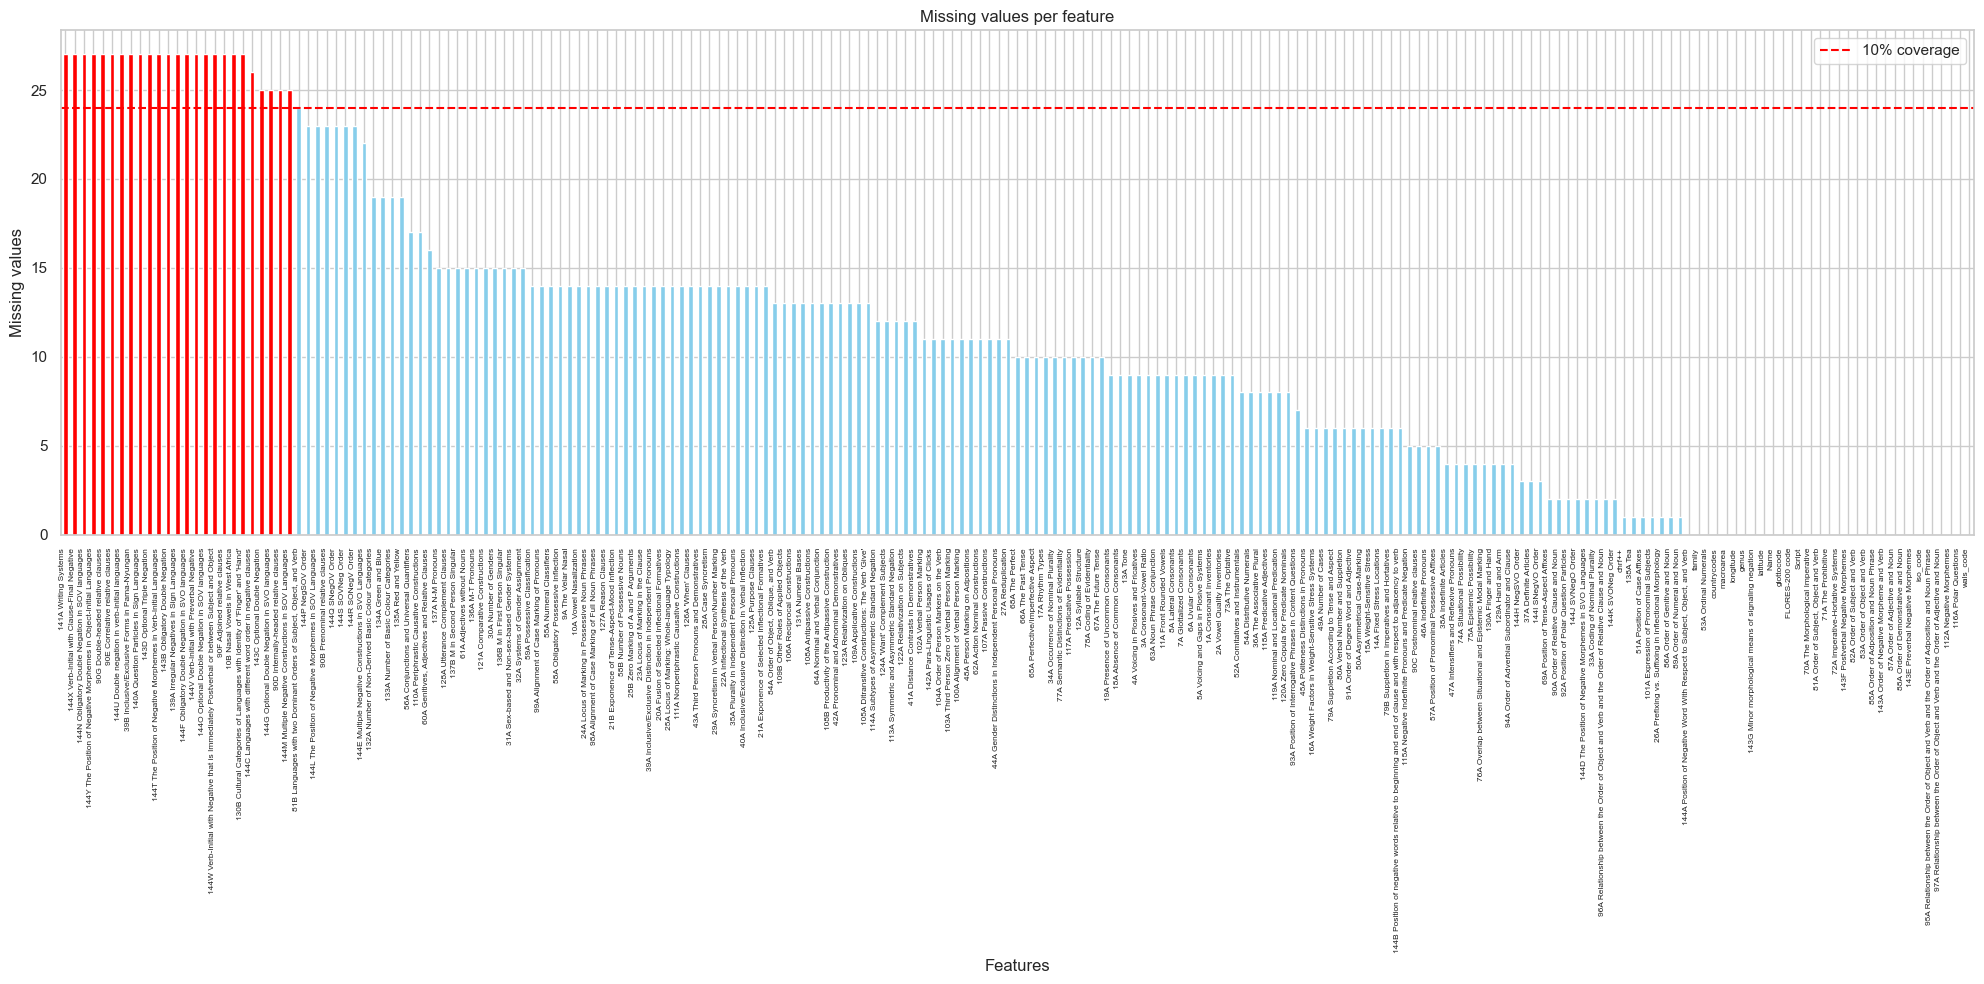

In [63]:
# remove features with <10% data for the selected languages
sns.set(style="whitegrid")

# missing value per characteristic (column)
missing_values = walsdata_test.isnull().sum(axis=0)
missing_values = missing_values.sort_values(ascending=False)

threshold = len(walsdata_test) - np.ceil(len(walsdata_test)/10)

colors = ['red' if value > threshold else 'skyblue' for value in missing_values]

fig, ax = plt.subplots(figsize=(20, 10))
missing_values.plot(kind='bar', color=colors, ax=ax)

plt.axhline(y=threshold, color='red', linestyle='--', label='10% coverage')  

# # Customize x-tick labels
xticklabels = [label for label in missing_values.index]
# xticklabels = [label if value > threshold else '' for label, value in zip(missing_values.index, missing_values)]
ax.set_xticklabels(xticklabels, fontsize=6 ,ha='right')

# Optional: Hide x-tick labels completely if not needed
# ax.set_xticklabels([])

plt.title("Missing values per feature")
plt.ylabel("Missing values")
plt.xlabel("Features")
plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
plt.legend()
plt.show()



In [ ]:
# missing value per characteristic (column)
missing_values = walsdata_test.isnull().sum(axis=0)
missing_values = missing_values.sort_values(ascending=False)

threshold = len(walsdata_test) - np.ceil(len(walsdata_test)/10)

features_above_threshold = missing_values[missing_values >= threshold].index.tolist()

# # remove from walsdata set
walsdata_test = walsdata_test.drop(columns=features_above_threshold)
walsdata_test

In [ ]:
# missing_values = pd.DataFrame(data = {'language' : walsdata_test['Name']})
# # missing_values['genus'] = walsdata_test[genus].isnull().sum(axis=1)
# # missing_values['family'] = walsdata_test[family].isnull().sum(axis=1)
# # missing_values['script'] = walsdata_test[script].isnull().sum(axis=1)
# missing_values['phonology'] = walsdata_test[phonology].isnull().sum(axis=1)
# missing_values['morphology'] = walsdata_test[morphology].isnull().sum(axis=1)
# missing_values['nominal_cat'] = walsdata_test[nominal_cat].isnull().sum(axis=1)
# missing_values['nominal_syn'] = walsdata_test[nominal_syn].isnull().sum(axis=1)
# missing_values['verbal_cat'] = walsdata_test[verbal_cat].isnull().sum(axis=1)
# missing_values['wordorder'] = walsdata_test[wordorder].isnull().sum(axis=1)
# missing_values['simple_clause'] = walsdata_test[simple_clause].isnull().sum(axis=1)
# missing_values['complex_sentences'] = walsdata_test[complex_sentences].isnull().sum(axis=1)
# missing_values['lexicon'] = walsdata_test[lexicon].isnull().sum(axis=1)
# # missing_values['Total'] = missing_values[['genus','family','script','phonology','morphology','nominal_cat','nominal_syn','verbal_cat','wordorder','simple_clause','complex_sentences','lexicon']].sum(axis=1)
# missing_values = missing_values.set_index('language')


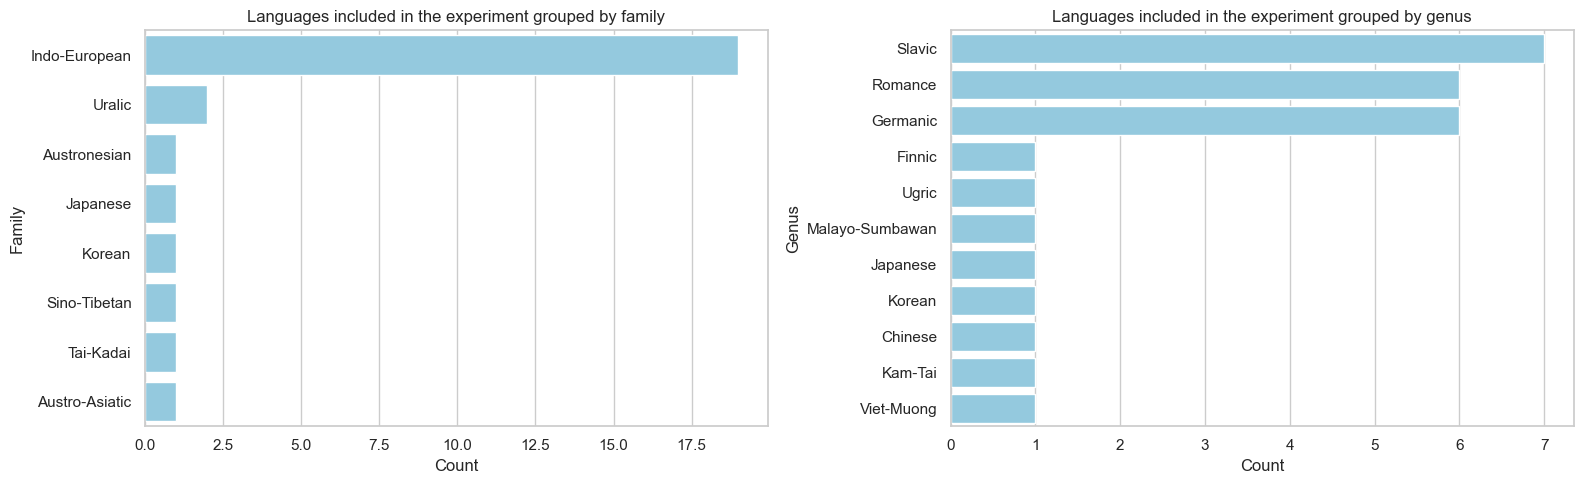

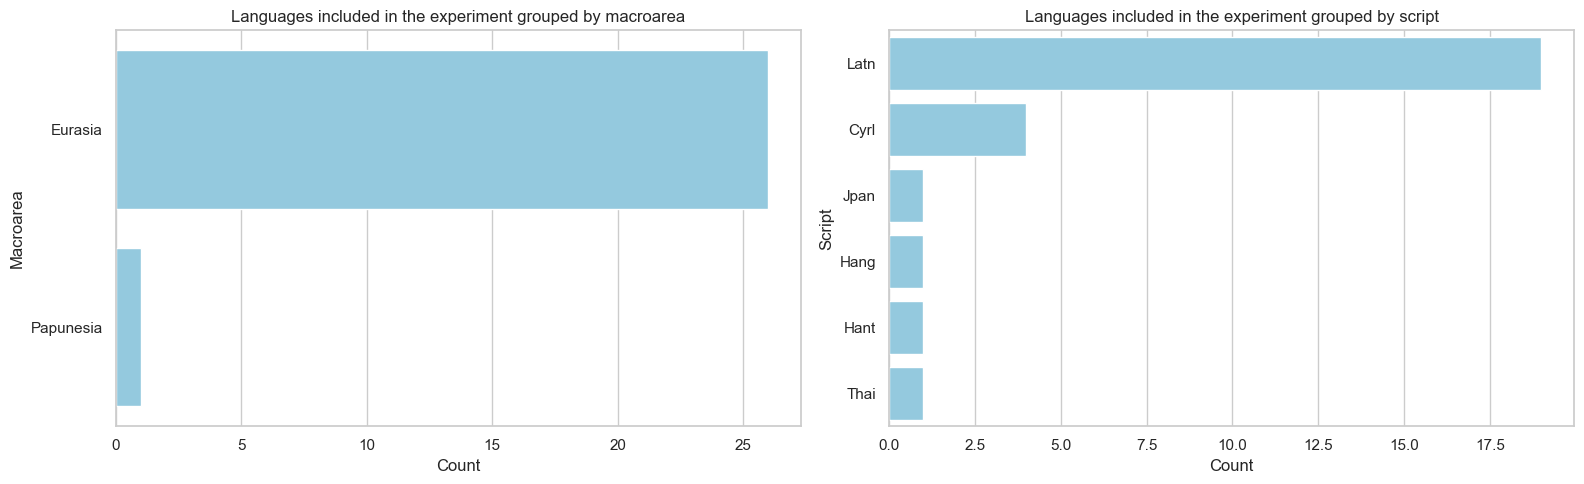

In [ ]:
# Set the style of seaborn
sns.set(style="whitegrid")

###### plots for family and genus

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Languages grouped by 'family'
sns.countplot(y="family", data=walsdata_test, order=walsdata_test['family'].value_counts().index, ax=axes[0], color='skyblue')
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Family")
axes[0].set_title("Languages included in the experiment grouped by family")
# axes[0].set_xticks(range(0, 8, 1))

# Plot 2: Languages grouped by 'genus'
sns.countplot(y="genus", data=walsdata_test, order=walsdata_test['genus'].value_counts().index, ax=axes[1],color='skyblue')
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Genus")
axes[1].set_title("Languages included in the experiment grouped by genus")
# axes[1].set_xticks(range(0, 8, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

###### plots for macroarea and script

# Create subplots with 1 row and 2 columns
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Languages grouped by 'family'
sns.countplot(y="macroarea", data=walsdata_test, order=walsdata_test['macroarea'].value_counts().index, ax=axes[0], color='skyblue')
axes[0].set_xlabel("Count")
axes[0].set_ylabel("Macroarea")
axes[0].set_title("Languages included in the experiment grouped by macroarea")
# axes[0].set_xticks(range(0, 8, 1))

# Plot 2: Languages grouped by 'script'
sns.countplot(y="Script", data=walsdata_test, order=walsdata_test['Script'].value_counts().index, ax=axes[1],color='skyblue')
axes[1].set_xlabel("Count")
axes[1].set_ylabel("Script")
axes[1].set_title("Languages included in the experiment grouped by script")
# axes[1].set_xticks(range(0, 8, 1))

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


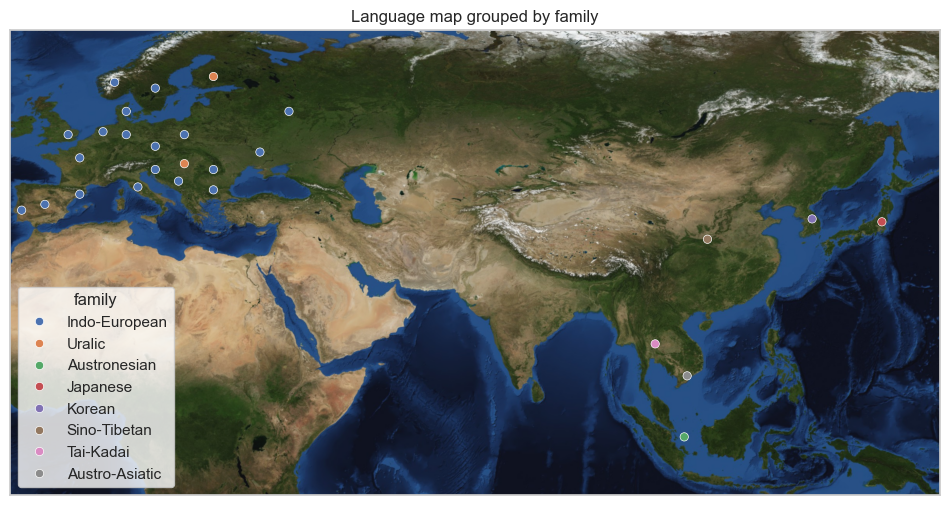

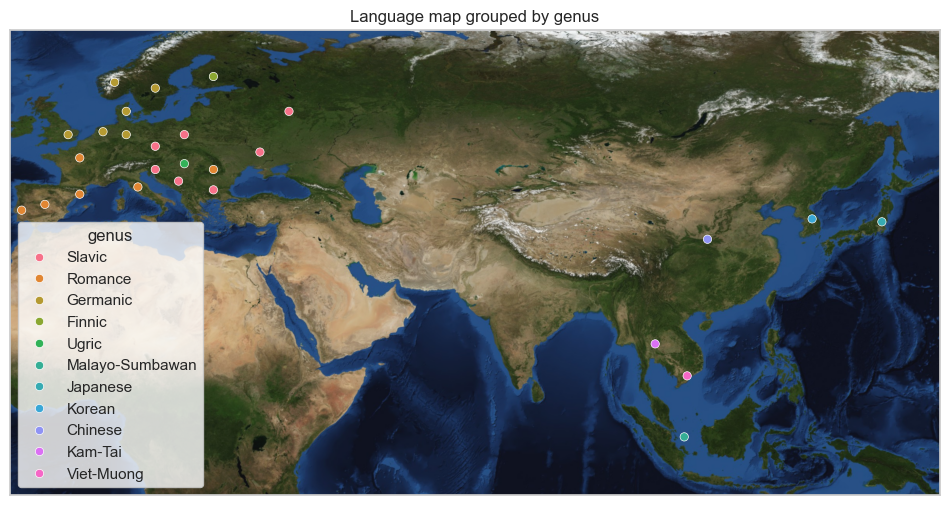

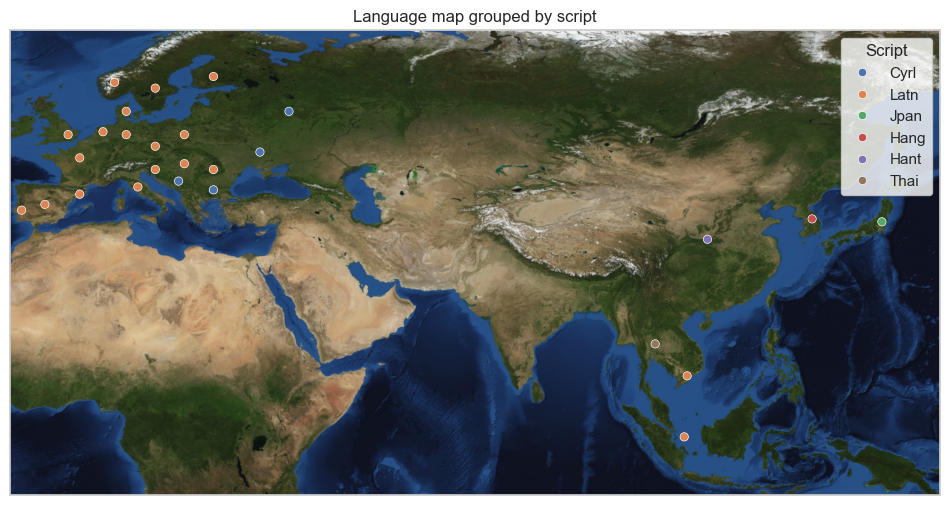

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.basemap import Basemap

# earth = Basemap()

# plt.figure(figsize=(22,14))
# earth.bluemarble(alpha=0.02)
# earth.drawcountries()
# earth.drawcoastlines(color='#888888', linewidth=1)

# sns.scatterplot(x='longitude', y='latitude', hue='family', data =walsdata_test, legend=False)

# plt.title("Language map")
# plt.show()

earth = Basemap(urcrnrlat=70,llcrnrlat=-10,llcrnrlon=-10,urcrnrlon=150)

plt.figure(figsize=(12,12))
earth.bluemarble(alpha=0.95)

sns.scatterplot(x='longitude', y='latitude', hue='family', data =walsdata_test, legend=True)

plt.title("Language map grouped by family")
plt.show()

earth = Basemap(urcrnrlat=70,llcrnrlat=-10,llcrnrlon=-10,urcrnrlon=150)

plt.figure(figsize=(12,12))
earth.bluemarble(alpha=0.95)

sns.scatterplot(x='longitude', y='latitude', hue='genus', data =walsdata_test, legend=True)

plt.title("Language map grouped by genus")
plt.show()

earth = Basemap(urcrnrlat=70,llcrnrlat=-10,llcrnrlon=-10,urcrnrlon=150)

plt.figure(figsize=(12,12))
earth.bluemarble(alpha=0.95)

sns.scatterplot(x='longitude', y='latitude', hue='Script', data =walsdata_test, legend=True)

plt.title("Language map grouped by script")
plt.show()

Visualize the ChrF++ score for each language that is included in the experiments

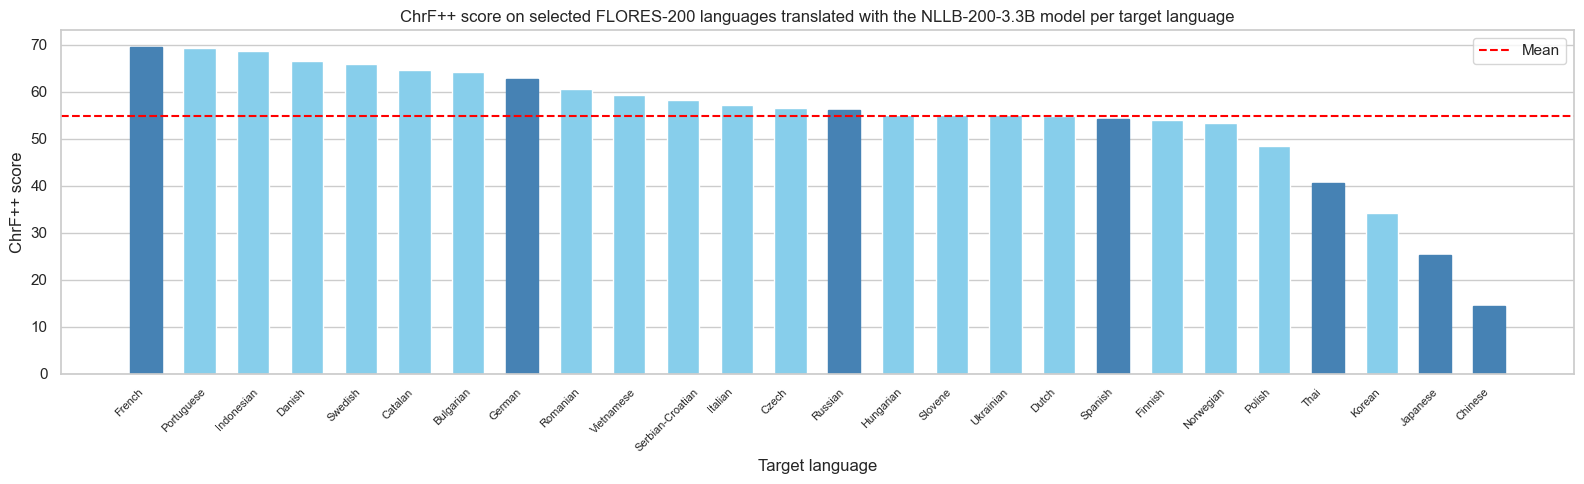

Mean ChrF++:  54.77307692307692


In [ ]:
# sort chrf++ values
nllb_chrf_sorted = walsdata_test.sort_values(by='chrf++', ascending=False)

# drop irrelevant row for English language
nllb_chrf_sorted = nllb_chrf_sorted.drop(nllb_chrf_sorted[nllb_chrf_sorted['Name'] == 'English'].index)

# extract mean chrf++ value
mean_chrf = np.mean(walsdata_test['chrf++'])

plt.figure(figsize=(16, 5))
bars = plt.bar(nllb_chrf_sorted['Name'], nllb_chrf_sorted['chrf++'], color='skyblue', width=0.6, align='edge')

# Add a horizontal line for mean
plt.axhline(y=mean_chrf, color='red', linestyle='--', label='Mean')  

 # Add the mgsm languages to label in darker blue
labels = ['French', 'Swahili', 'Russian', 'Chinese', 'Japanese', 'Telugu', 'Bengali', 'Spanish', 'German', 'Thai'] 
for bar, label in zip(bars, nllb_chrf_sorted['Name']):
    if label in labels:
        bar.set_color('steelblue')

plt.xlabel('Target language')
plt.ylabel('ChrF++ score')
plt.title('ChrF++ score on selected FLORES-200 languages translated with the NLLB-200-3.3B model per target language')
plt.xticks(rotation=45, fontsize=8)
plt.grid(False, axis='x')
plt.legend()
plt.tight_layout()  
plt.show()

print('Mean ChrF++: ', mean_chrf)

In [ ]:

def get_wals_data(lang):
    """
    Get the wals dataframe row of a specific language.
    
    Parameters:
    lang: wals_code of the language of interest.
    
    Returns:
    pd.series row of the wals data for the language.
    """
    return walsdata.loc[walsdata['wals_code'] == lang] # .values.flatten().tolist() get list of walsdata row for a requested language

def calc_distance(lang1,lang2):
    """
    Calculate the Haversine distance between the geographical locations of two 
    languages given the wals_codes.
    
    Parameters:
    lang1, lang2: wals_code of two languages to be compared.
    
    Returns:
    Rounded distance between the geographical location of the languages in kilometers.
    """

    # get df for both languages
    wals_lang1 = get_wals_data(lang1)
    wals_lang2 = get_wals_data(lang2)
    
    lat1 = wals_lang1['latitude']
    lon1 = wals_lang1['longitude']
    lat2 = wals_lang2['latitude']
    lon2 = wals_lang2['longitude']

    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Radius of the Earth (mean value in kilometers)
    radius_earth = 6371

    # Calculate the distance
    distance = radius_earth * c

    return round(distance)

def get_distance_df(langlist):
    """
    Calculate the Haversine distance between the geographical locations of a 
    list of languages with the wals_codes and creates a df with the pairwise
    distances.
    
    Parameters:
    langlist: list with wals_codes of languages to be compared.
    
    Returns:
    Rounded distance between the geographical location of the languages in kilometers.
    """
    df = pd.DataFrame(index=langlist, columns=langlist)

    for lang1 in langlist:
        for lang2 in langlist:
            df.loc[lang1,lang2] = calc_distance(lang1,lang2)

    return df


In [ ]:
df = get_distance_df(walsdata_test['wals_code'])

pairs = []
distances = []

for i in range(len(df)):
    for j in range(i+1, len(df)): 
        if df.iloc[i, j] != 0:

            pairs.append(f"{df.index[i]}-{df.columns[j]}")
            distances.append(df.iloc[i, j])

distance_pairs_df = pd.DataFrame({'Language pair': pairs, 'Distance': distances})
distance_pairs_df = distance_pairs_df.sort_values(by='Distance')
print(distance_pairs_df.head(10))
print(distance_pairs_df.tail(10))

   Language pair  Distance
25       por-spa       361
7        eng-fre       467
5        ctl-spa       541
1        ctl-fre       695
4        ctl-por       900
16       fre-spa      1010
0        ctl-eng      1150
21       ind-vie      1169
15       fre-por      1283
11       eng-spa      1369
   Language pair  Distance
12       eng-vie     10188
17       fre-vie     10194
6        ctl-vie     10405
27       spa-vie     10945
13       fre-ind     11043
8        eng-ind     11094
2        ctl-ind     11164
26       por-vie     11305
20       ind-spa     11696
19       ind-por     12057


C:\Users\maras\AppData\Local\Temp\ipykernel_22304\2995789046.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])


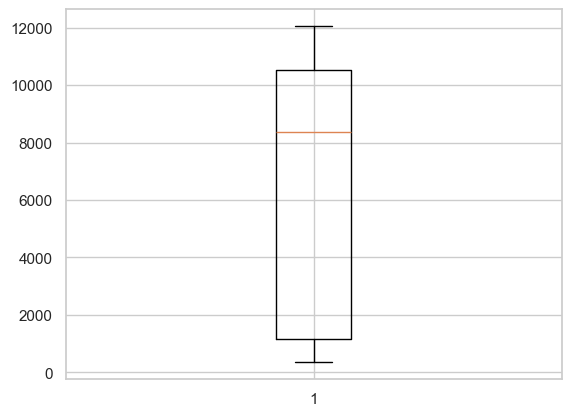

In [ ]:
plt.boxplot(distance_pairs_df['Distance'])
plt.show()

# based on this label with close-geo and far-geo like in winata et al. 2022?
# or pick for each language the closest lang based on distance?

In [ ]:
df = get_distance_df(walsdata_test['wals_code'])
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df

C:\Users\maras\AppData\Local\Temp\ipykernel_22304\2995789046.py:35: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])


wals_code,bul,ctl,cze,dsh,dut,eng,fin,fre,ger,hun,...,por,rom,rus,scr,slo,spa,swe,tha,ukr,vie
wals_code,,,,,,,,,,,,,,,,,,,,,
bul,0,1893,1132,1846,1800,2147,2168,1893,1543,637,...,2789,389,1767,514,886,2428,2061,7677,952,8527
ctl,1893,0,1358,1686,1233,1150,2718,695,1290,1541,...,900,1896,3023,1405,1142,541,2216,9553,2531,10405
cze,1132,1358,0,746,685,1071,1468,973,414,497,...,2182,866,1667,733,445,1853,1112,8370,1301,9222
dsh,1846,1686,746,0,468,789,1083,1043,445,1214,...,2309,1523,1729,1478,1165,2053,533,8600,1729,9441
dut,1800,1233,685,468,0,412,1546,575,278,1174,...,1846,1550,2095,1345,973,1585,1000,8934,1927,9781
eng,2147,1150,1071,789,412,0,1859,467,684,1541,...,1572,1930,2490,1663,1278,1369,1283,9342,2337,10188
fin,2168,2718,1468,1083,1546,1859,0,2117,1429,1698,...,3391,1779,996,2039,1890,3125,582,7712,1528,8535
fre,1893,695,973,1043,575,467,2117,0,724,1354,...,1283,1752,2585,1383,1009,1010,1576,9342,2271,10194
ger,1543,1290,414,445,278,684,1429,724,0,910,...,2004,1278,1869,1112,760,1711,942,8680,1653,9529


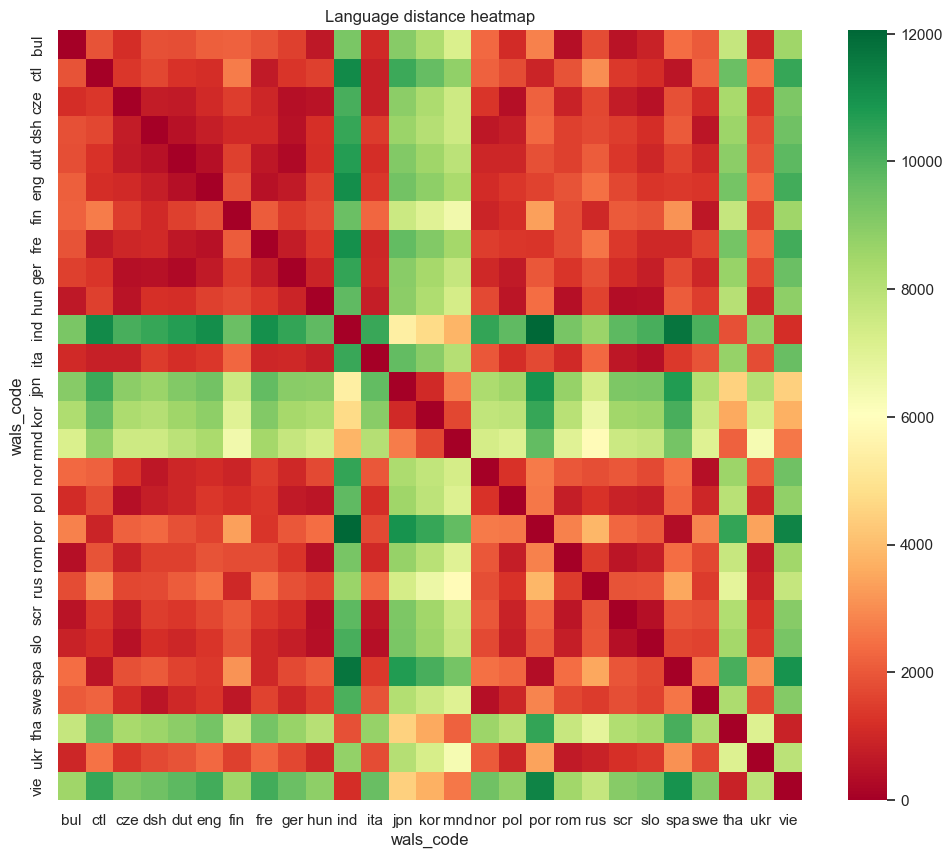

In [ ]:
plt.figure(figsize=(12, 10))
sns.heatmap(df, annot=False, cmap='RdYlGn', fmt=".2f")
plt.title('Language distance heatmap')
plt.show()

### References

1. Cobbe, K., Kosaraju, V., Bavarian, M., Chen, M., Jun, H., Kaiser, L., ... & Schulman, J. (2021). Training verifiers to solve math word problems. arXiv preprint arXiv:2110.14168.
2. Shi, F., Suzgun, M., Freitag, M., Wang, X., Srivats, S., Vosoughi, S., ... & Wei, J. (2022). Language models are multilingual chain-of-thought reasoners. arXiv preprint arXiv:2210.03057.
3. Qin, L., Chen, Q., Wei, F., Huang, S., & Che, W. (2023). Cross-lingual prompting: Improving zero-shot chain-of-thought reasoning across languages. arXiv preprint arXiv:2310.14799.
4. Huang, H., Tang, T., Zhang, D., Zhao, W. X., Song, T., Xia, Y., & Wei, F. (2023). Not All Languages Are Created Equal in LLMs: Improving Multilingual Capability by Cross-Lingual-Thought Prompting. arXiv preprint arXiv:2305.07004.
5. Ponti, E. M., Glavaš, G., Majewska, O., Liu, Q., Vulić, I., & Korhonen, A. (2020). XCOPA: A multilingual dataset for causal commonsense reasoning. arXiv preprint arXiv:2005.00333.
6. Roemmele, M., Bejan, C. A., & Gordon, A. S. (2011, March). Choice of plausible alternatives: An evaluation of commonsense causal reasoning. In 2011 AAAI Spring Symposium Series.
7. Dryer, Matthew S. & Haspelmath, Martin (eds.) 2013. WALS Online (v2020.3) [Data set]. Zenodo. https://doi.org/10.5281/zenodo.7385533 (Available online at https://wals.info, Accessed on 2024-01-30.)
8. Unicode CLDR (2023). Languages and scripts. Retrieved from https://www.unicode.org/cldr/charts/44/supplemental/languages_and_scripts.html
9. Costa-jussà, M. R., Cross, J., Çelebi, O., Elbayad, M., Heafield, K., Heffernan, K., ... & NLLB Team. (2022). No language left behind: Scaling human-centered machine translation. arXiv preprint arXiv:2207.04672.
10. Touvron, H., Martin, L., Stone, K., Albert, P., Almahairi, A., Babaei, Y., ... & Scialom, T. (2023). Llama 2: Open foundation and fine-tuned chat models. arXiv preprint arXiv:2307.09288.
11. Muennighoff, N., Wang, T., Sutawika, L., Roberts, A., Biderman, S., Le Scao, T., ... & Raffel, C. Crosslingual Generalization through Multitask Finetuning, 2022. URL https://arxiv. org/abs/2211.01786.